In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
states = np.load('data_msd/test_states-1-3-0.1-nonlinear.npy')
forces = np.load('data_msd/forces1-3-0.1-nonlinear.npy')

In [3]:
states.shape

(100, 10001, 2)

- states[t = 0] - states[t = T+1]
- forces[t = 0] - forces[t = T]

lets test if the previous method would work

In [4]:
states_std = np.std(states.reshape(-1,2),axis=0)
forces_std = np.std(forces,axis=0)

states_mean = np.array([0,0])
forces_mean = np.array([0])

In [5]:
states_norm = (states-states_mean)/states_std
forces_norm = (forces-forces_mean)/forces_std

forces_norm = np.tile(forces_norm,(100,1))

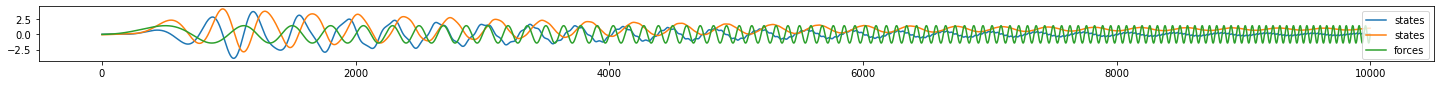

In [6]:
plt.figure(figsize=(25,1))
plt.plot(range(states_norm[0].shape[0]-1),states_norm[0][:-1],label = 'states')
plt.plot(range(forces_norm[0].shape[0]),forces_norm[0], label = 'forces')
plt.legend()
plt.show()

In [7]:
X = np.append(states_norm[:,:-1,:],forces_norm[:,:,np.newaxis],axis=2)

y = states_norm[:,1:,:].copy()

X = X.reshape(-1,3)
y = y.reshape(-1,2)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.INPUT = 3
        self.OUTPUT = 2
        self.HIDDEN = 20
        self.fc_1 = nn.Sequential(nn.Linear(self.INPUT,self.HIDDEN),nn.Softplus())
        self.fc_hidden = nn.Sequential(nn.Linear(self.HIDDEN,self.HIDDEN),nn.Softplus())
        self.fc_hidden2 = nn.Sequential(nn.Linear(self.HIDDEN,self.HIDDEN),nn.Softplus())
        self.fc_2 = nn.Linear(self.HIDDEN,self.OUTPUT)
    
    def forward(self,x):
        x = self.fc_1(x)
        x = self.fc_hidden(x)
        x = self.fc_hidden2(x)
        x = self.fc_2(x)
        return x

In [9]:
X_tensor = torch.Tensor(X)
y_tensor = torch.Tensor(y)

X_tensor = X_tensor[:-10000]
y_tensor = y_tensor[:-10000]

X_test_tensor = X_tensor[-10000:].cuda()
y_test_tensor = y_tensor[-10000:].cuda()

dataset = TensorDataset(X_tensor,y_tensor)

dataloader = DataLoader(dataset,batch_size = 1000,shuffle=True)

In [10]:
net = Net().cuda()
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr = 0.001,weight_decay = 0.001)

In [11]:
EPOCH = 1
losses = []
test_losses = []

net.train()
for epoch in range(EPOCH):
    for i,batch in enumerate(dataloader):
        X_batch, y_batch = batch
        X_batch = X_batch.cuda()
        y_batch = y_batch.cuda()
        
        optimizer.zero_grad()
        output = net(X_batch)
        loss = loss_function(output, y_batch)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                test_output = net(X_test_tensor)
                test_loss = loss_function(test_output,y_test_tensor)
            
                losses.append(loss)
                test_losses.append(test_loss)
                clear_output(wait=True)
                print(epoch,loss,test_loss)

0 tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0002, device='cuda:0')


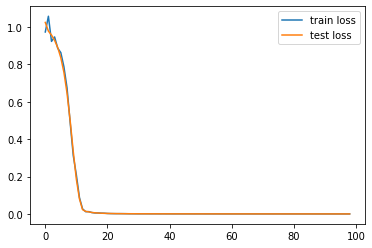

In [12]:
plt.plot(range(len(losses)),losses,label = 'train loss')
plt.plot(range(len(test_losses)),test_losses,label = 'test loss')
plt.legend()
plt.show()

In [13]:
net.eval()
with torch.no_grad():
    X_testing = X_tensor[:10000].cuda()
    output = net(X_testing)
output = output.cpu()

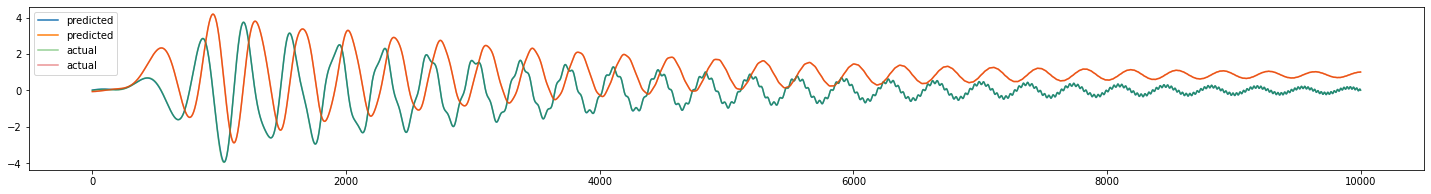

In [14]:
plt.figure(figsize=(25,3))
plt.plot(range(output.shape[0]),output,label = 'predicted')
plt.plot(range(output.shape[0]),y_tensor[:output.shape[0]], label = 'actual',alpha=0.5)
plt.legend()
plt.show()

In [15]:
time = np.linspace(0,100,10000,endpoint = False)

initial_states = torch.Tensor(np.array([1/states_std[0],-1/states_std[1]]))
simulated_forces = torch.Tensor(np.sin(time)/forces_std)
#simulated_forces = torch.Tensor(np.zeros_like(time))

In [16]:
simulated_states = []

simulated_output = initial_states
net.eval()
with torch.no_grad():
    for i in range(len(simulated_forces)):
        inp = torch.cat((simulated_output.cuda(),torch.Tensor([simulated_forces[i]]).cuda()),dim=0).cuda()
        simulated_output = net(inp)
        simulated_states.append(simulated_output.cpu().numpy())

In [17]:
simulated_states = np.array(simulated_states)
simulated_states = simulated_states*states_std

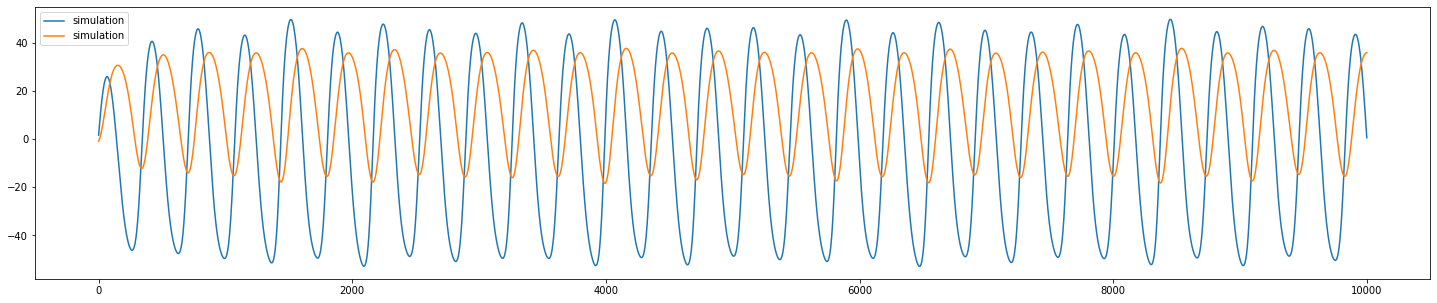

In [19]:
plt.figure(figsize=(25,5))
plt.plot(range(simulated_states.shape[0]),simulated_states,label='simulation')
#plt.ylim([-2.5,2.5])
plt.legend()
plt.show()